In [11]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import arviz as az
import theano
THEANO_FLAGS = "optimizer=fast_compile"

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

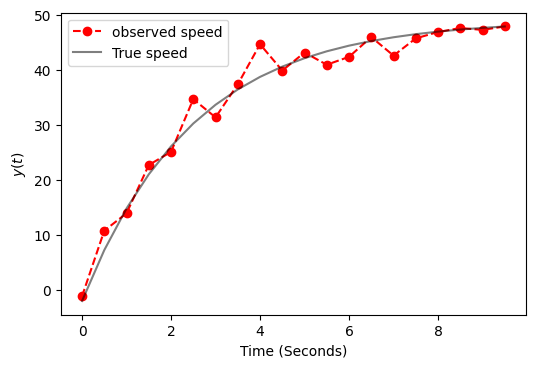

In [4]:
def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0]

# Times for observation
times = np.arange(0, 10, 0.5)
gamma, g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma, g]]))
yobs = np.random.normal(y, 2)

fig, ax = plt.subplots(dpi=100)
plt.plot(times, yobs, label="observed speed", linestyle="dashed", marker="o", color="red")
plt.plot(times, y, label="True speed", color="k", alpha=0.5)
plt.legend()
plt.xlabel("Time (Seconds)")
plt.ylabel(r"$y(t)$")
plt.show()

In [5]:
ode_model = DifferentialEquation(func=freefall, times=times, n_states=1, n_theta=2, t0=0)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    sigma = pm.HalfCauchy("sigma", 1)
    gamma = pm.Lognormal("gamma", 0, 1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 553 seconds.
The acceptance probability does not match the target. It is 0.8804536631623957, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
data = az.from_pymc3(trace=trace)

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'gamma'}>], dtype=object)

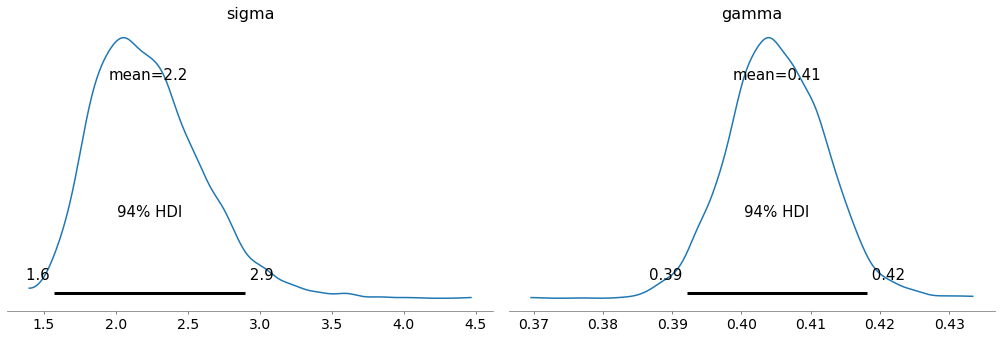

In [9]:
az.plot_posterior(data, round_to=2)

In [13]:
fluos = []
ods = []
for i in range(4):
    fluos.append(pd.read_csv('datasets/bulk_fluo_mario_' + '{:02b}'.format(int(i)) + '.csv', index_col='time').iloc[:,:9])
    ods.append(pd.read_csv('datasets/od_mario_' + '{:02b}'.format(int(i)) + '.csv', index_col='time').iloc[:,:9])
gates = fluos[0].columns.tolist()

In [14]:
sel = 3
gate = gates[sel]
print(sel, gate)
fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)

3 e20x32gp411


In [12]:
fluo = pd.read_csv('datasets/fluoOD-all.csv')
od = pd.read_csv('datasets/OD-all.csv')

fluo = fluo.replace('n.a.', 0)
od = od.replace('n.a.', 0)
raw_fluo = fluo.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)
raw_od = od.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)

raw_both = raw_fluo * raw_od
df = pd.concat([fluo[['ECF', 'Intein', 'Ara', 'Cuma']], raw_both], axis=1)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/fluoOD-all.csv'

In [3]:
df2 = df[(df['Ara']==1) & (df['Cuma']==1)]
df2 = df2.set_index(df2['ECF'] + df2['Intein'])
df2 = df2.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df2['new_index'] = df2.index.str[7:12]
df2 = df2.set_index('new_index')
df2.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,21.62500,14.10682,-10.20240,-14.73152,33.51864,54.76527,30.03510,30.74070,76.93035,98.94185,...,62.13312,17.90467,-6.91299,24.62000,76.44860,19.578000,-10.77699,24.425500,12.62616,31.97744
00:20,-101.37366,64.33200,63.38460,87.34615,175.67310,99.96154,89.73077,173.29753,127.39316,161.16140,...,-129.68964,-137.81250,-85.89522,62.82879,126.96154,92.153847,109.12588,107.615385,156.70011,160.07416
00:40,-52.95490,-38.89568,-37.80715,-46.18264,-12.37340,-2.86740,-48.26601,-15.48820,-18.92473,20.74640,...,-42.28900,-63.66528,-55.83582,-41.68976,-12.08031,-17.210700,-12.37340,-42.180800,13.03740,58.06452
01:00,-98.18847,-10.39050,23.09808,-15.46116,52.78819,24.15460,31.13992,42.37074,37.52530,56.37600,...,-87.81814,-119.76525,-93.24080,-7.20240,47.33113,-13.380450,5.12220,27.694420,7.57491,61.09570
01:20,-53.51717,13.43900,6.63873,4.95120,42.97700,18.45877,25.04068,60.71615,64.04811,27.90936,...,-61.15626,-95.25761,-49.29870,-0.86548,22.69449,7.170800,8.86480,-0.989730,33.28956,44.47770


In [4]:
df3 = od[(od['Ara']==1) & (od['Cuma']==1)]
df3 = df3.set_index(df3['ECF'] + df3['Intein'])
df3 = df3.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df3['new_index'] = df3.index.str[7:12]
df3 = df3.set_index('new_index')
df3.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,0.025,0.026,0.040,0.032,0.024,0.0210,0.0300,0.010,0.015,-0.001,...,0.002,0.007,0.021,0.020,0.0100,0.0200,0.021,0.0250,0.024,0.016
00:20,0.018,0.004,0.004,0.001,-0.006,-0.0004,-0.0002,-0.007,-0.004,-0.005,...,0.018,0.021,0.017,0.003,-0.0004,0.0003,-0.002,-0.0001,-0.007,-0.008
00:40,0.019,0.016,0.017,0.014,0.010,0.0120,0.0130,0.007,0.011,0.008,...,0.013,0.018,0.017,0.014,0.0110,0.0130,0.010,0.0160,0.006,0.002
01:00,0.031,0.015,0.012,0.011,0.007,0.0100,0.0070,0.003,0.005,0.009,...,0.023,0.033,0.029,0.015,0.0110,0.0150,0.010,0.0130,0.007,0.002
01:20,0.037,0.020,0.021,0.016,0.011,0.0170,0.0140,0.005,0.007,0.018,...,0.022,0.037,0.033,0.022,0.0170,0.0260,0.016,0.0210,0.012,0.005


[0.30576577 1.04091593]


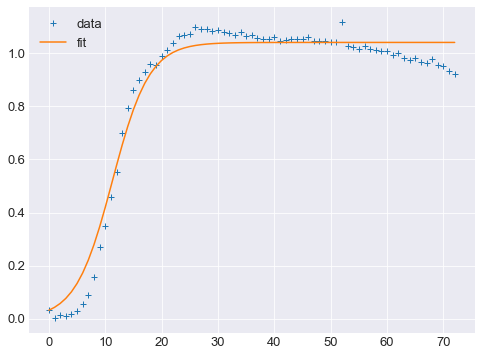

In [5]:
col = 3
odata = df3[df3.columns[col]]
t = list(range(0, len(odata.index)))

def testfunc(t, k1, k2):
    
    def cell_density_model(OD, t, max_growth_rate, max_carry_capacity):
        dOD = (max_growth_rate * (1 - (OD[0]/max_carry_capacity))) * OD[0]
        return dOD
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

k_fit, kcov = curve_fit(testfunc, t, odata)
print(k_fit)
fit = testfunc(t, *k_fit)

plt.plot(t, odata, '+', label='data')
plt.plot(t, fit, '-', label='fit')
plt.legend(loc='best')
plt.show()

In [10]:
def and_gate(y, t, p):
        
    an = p[0]
    dn = p[1]
    ac = p[2]
    dc = p[3]
    ae = p[4]
    de = p[5]
    ag = p[6]
    dg = p[7]
    K = p[8]
    n = p[9]

    OD = y[0]
    ECF_n = y[1]
    ECF_c = y[2]
    ECF = y[3]
    GFP = y[4]
    mgc = k_fit[0]
    mgr = k_fit[1]

    dOD = mgr * (1 - (OD/mgc)) * OD
    dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
    dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
    dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
    dGFP = ag * ((ECF**n) / (ECF**n+ K**n))  - (dg + (mgr * (1 - (OD/mgc)))) * GFP

    return [dOD, dECF_n, dECF_c, dECF, dGFP]

In [46]:
fdata = df2[df2.columns[col]].values
fobs = [[i, i, i, i, i] for i in fdata]
t = [i*20 for i in list(np.arange(len(fdata)))]

gate_ode = DifferentialEquation (
    func = and_gate,
    times = t,
    n_states = 5,
    n_theta = 10
)

with pm.Model() as basic_model:
    
    an = pm.Normal("an", mu=0, sigma=2)
    dn = pm.Normal("dn", mu=0, sigma=2)
    ac = pm.Normal("ac", mu=0, sigma=2)
    dc = pm.Normal("dc", mu=0, sigma=2)
    ae = pm.Normal("ae", mu=0, sigma=2)
    de = pm.Normal("de", mu=0, sigma=2)
    ag = pm.Normal("ag", mu=0, sigma=2)
    dg = pm.Normal("dg", mu=0, sigma=2)
    K = pm.Normal("K", mu=0, sigma=2)
    n = pm.Normal("n", mu=0, sigma=2)
    
    gate_model = gate_ode(y0=[np.abs(odata[0]), 0.01, 0.01, 0.01, np.abs(fdata[0])],
                         theta=[an, dn, ac, dc, ae, de, ag, dg, K, n])
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=gate_model, sd=sigma, observed=fobs)
    
    step = pm.Metropolis()
    trace = pm.sample(100, step=step)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'an': array(0.), 'dn': array(0.), 'ac': array(0.), 'dc': array(0.), 'ae': array(0.), 'de': array(0.), 'ag': array(0.), 'dg': array(0.), 'K': array(0.), 'n': array(0.), 'sigma_log__': array(-0.22579135)}

Initial evaluation results:
an            -1.61
dn            -1.61
ac            -1.61
dc            -1.61
ae            -1.61
de            -1.61
ag            -1.61
dg            -1.61
K             -1.61
n             -1.61
sigma_log__   -0.77
Y_obs           NaN
Name: Log-probability of test_point, dtype: float64

In [ ]:
def simplest_hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, xCa0):
    
    an = xan
    dn = xdn
    ac = xac
    dc = xdc
    ae = xae
    de = xde
    ag = xag
    dg = xdg
    mgr = k_fit[0]
    mgc = k_fit[1]
    K = xK
    n = xn
    Ca0 = xCa0
    
    def andGate(y, t):
        
        [OD, ECF_n, ECF_c, ECF, GFP] = y
        dOD = mgr * (1 - (OD/mgc)) * OD
        dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
        dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
        dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
        dGFP = ag * simplest_hill_equation(ECF, K, n)  - (dg + (mgr * (1 - (OD/mgc)))) * GFP
        
        return [dOD, dECF_n, dECF_c, dECF, dGFP]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,4]

def modelfit(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn):
    return fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, Ca0)

In [45]:
fdata = df2[df2.columns[col]].values
t = [i*20 for i in list(np.arange(len(fdata)))]

gate_ode = DifferentialEquation (
    func = and_gate,
    times = t,
    n_states = 5,
    n_theta = 10
)

with pm.Model() as basic_model:
    
    an = pm.Normal("an", mu=0, sigma=2)
    dn = pm.Normal("dn", mu=0, sigma=2)
    ac = pm.Normal("ac", mu=0, sigma=2)
    dc = pm.Normal("dc", mu=0, sigma=2)
    ae = pm.Normal("ae", mu=0, sigma=2)
    de = pm.Normal("de", mu=0, sigma=2)
    ag = pm.Normal("ag", mu=0, sigma=2)
    dg = pm.Normal("dg", mu=0, sigma=2)
    K = pm.Normal("K", mu=0, sigma=2)
    n = pm.Normal("n", mu=0, sigma=2)
    
    gate_model = fitfunc(t, an, dn, ac, dc, ae, de, ag, dg, K, n,
                         y0[np.abs(odata[0]), 0.01, 0.01, 0.01, np.abs(fdata[0])])
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=gate_model, sd=sigma, observed=fobs)
    
    step = pm.Metropolis()
    trace = pm.sample(100, step=step)

ValueError: setting an array element with a sequence.